### Import Modules

In [1]:
# Python Libraries
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [2]:
# Our Modules
from modules.data_preprocessing import DataPreprocessing
from modules.transformer import Transformer

### Parameters

In [3]:
data_path = fr"D:\courses\Transformers\Data\eng_french.csv"
max_sentence_length = 30
batch_size = 32
embedding_dim = 512
num_encoders = 1
num_decoders = 1
num_multiheads = 8
encoder_hidden_layer_size = 2048
decoder_hidden_layer_size = 2048
epochs = 1

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Preprocess Data

In [5]:
preprocess = DataPreprocessing(
    data_path = data_path,
    max_sentence_length = max_sentence_length,
    batch_size = batch_size
)
dataset, dataloader = preprocess.forward()

Loading Data from D:\courses\Transformers\Data\eng_french.csv
Creating English vocabulary...
Creating French vocabulary...
Converting English Sentences to integer...
Converting French Sentences to integer for decoder input ...
Converting French Sentences to integer for decoder output ...
Preparing Dataset for Input...
Done.


### Get Output

In [6]:
transformer = Transformer(
    batch_size,
    max_sentence_length,
    embedding_dim,
    num_multiheads,
    num_encoders,
    num_decoders,
    encoder_hidden_layer_size,
    decoder_hidden_layer_size,
    english_vocab_size = preprocess.english_vocab_size + 1,
    french_vocab_size = preprocess.french_vocab_size + 1
)
transformer = transformer.to(device)

In [7]:
total_params = sum(p.numel() for p in transformer.parameters() if p.requires_grad)
print(f"Total number of parameters in the model are: {total_params}")

Total number of parameters in the model are: 36744826


In [8]:
preprocess.french_vocab_size + 1

24186

In [11]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(transformer.parameters(), lr = 0.0001)

In [12]:
losses = []
for ep in range(epochs):
    for batch in tqdm(dataloader, desc = f"Epoch: {ep}"):
        optimizer.zero_grad()
        
        encoder_input, decoder_input, ground_truths = batch

        encoder_input = encoder_input.to(device)
        decoder_input = decoder_input.to(device)
        ground_truths = ground_truths.to(device)
    
        decoder_prediction = transformer.forward(encoder_input, decoder_input).float()

        ground_truths = F.one_hot(ground_truths, num_classes=preprocess.french_vocab_size + 1).float()
        
        loss = criterion(decoder_prediction, ground_truths)

        loss.backward()

        optimizer.step()
        losses.append(loss.item())
        

Epoch: 0:   0%|          | 0/5489 [00:00<?, ?it/s]

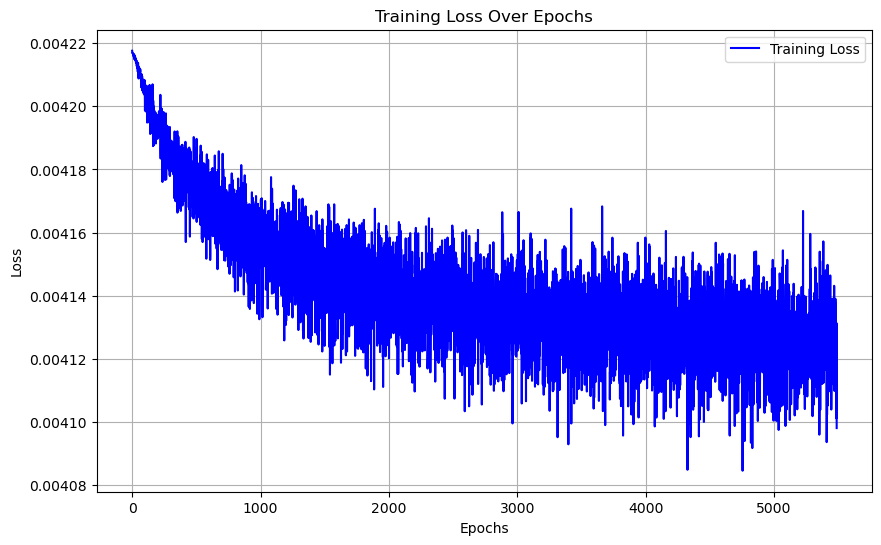

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(losses, label='Training Loss', color='blue')  # Plot loss values
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.title('Training Loss Over Epochs')  # Plot title
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()  # Display the plot

### Inference

In [16]:
# input_test = ["Hello"]
# decoder_input = [""]
# encoder_input = torch.Tensor(preprocess.convert_sentences_integers(input_test, preprocess.english_word_int, preprocess.english_int_word, type = "encoder_input"))
# decoder_input = torch.Tensor(preprocess.convert_sentences_integers(decoder_input, preprocess.french_word_int, preprocess.french_int_word, type = "decoder_input"))
# print(encoder_input, decoder_input)

In [17]:
# encoder_input = encoder_input.to(device)
# decoder_input = decoder_input.to(device)


# decoder_output = transformer.forward(encoder_input.long(), decoder_input.long()).float()

# result = torch.argmax(decoder_output, dim=-1)

# sentence_outputs = [' '.join([preprocess.french_int_word[int(num)] for num in row]) for row in result]
# print(sentence_outputs)

    